# <font size = 5>Setting up</font>

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import sys
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter
import pandas as pd
from qutip import *
import scipy.constants
import pickle
from tkinter import filedialog # for prompting user to set analysis folder
import glob
import h5py
from pathlib import PureWindowsPath, PurePosixPath
from tqdm import tqdm
from joblib import Parallel, delayed
import numba
from sympy.physics.wigner import wigner_3j, wigner_6j
from scipy.integrate import quad, nquad
import numpy as np

In [2]:
# suppress warnings: do at your own risk!
import warnings
warnings.filterwarnings("ignore")

In [3]:
# constants
ABSORPTION_LIMIT = 5.0
SPECIAL_CHARACTERS = "!@#$%^&*()-+?_=,<>/"

# physics constants
hbar = 1.05457182*10**(-34) # Js
c = 299792458 # m/s
h_planck = hbar*2*np.pi  # Js
me = 9.1093837015e-31    # electron mass
mn = 1.67493e-27         # neutron mass
eC = 1.60218e-19         # electric charge
muB = eC*hbar/(2*me)     # Bohr magneton
muB_cm1_G = muB / (100*c*h_planck*1e4) # Bohr magneton in units of cm-1 per Gauss
a0 = 5.2917720859e-11    # Bohr radius
muN = scipy.constants.physical_constants['nuclear magneton'][0]
eps0 = scipy.constants.epsilon_0
gS = 2.0023193043622
kB = 1.380649e-23 # Boltzmann constant
DebyeSI = 3.33564e-30

# Lithium constants
mLi6 = 9.9883414*10**(-27) # kg
Li6D2Gamma = 5.8724e6 # Hz Note that this is NOT angular freq
Li6D2lambda0 = 670.977338*10**(-9) # meters
Li6D2sigma0 = 3*(Li6D2lambda0)**2/(2*np.pi)
Li6Ahf_s12 = 152.1368407e6  # This is NOT angular freq
Li6Bhf_s12 = 0
Li6Ahf_p12 = 17.386e6 # Hz
Li6Bhf_p12 = 0
Li6Ahf_p32 = -1.155e6 # Hz
Li6Bhf_p32 = -0.10e6 # Hz
Li6I = 1
Li6gI = -0.0004476540

# Sodium-23 constants
mNa23 = 0.38175403519e-25 # kg
Na23D2Gamma = 9.794646e6 # Hz
Na23D2lambda0 = 589.158326415e-9 # meters
Na23D2sigma0 = 3*(Na23D2lambda0)**2/(2*np.pi)
Na23Ahf_s12 = 885.8130644050e6 # Hz
Na23Bhf_s12 = 0e6 # Hz
Na23Ahf_p12 = 94.4413e6 # Hz
Na23Bhf_p12 = 0e6 # Hz
Na23Ahf_p32 = 18.53415e6 # Hz
Na23Bhf_p32 = 2.72430e6 # Hz
Na23I = 3/2
Na23gI = -0.0008046108080

# Potassium-40 constants
mK40 = 39.9639984821*1.6605402e-27 # kg 
K40D2Gamma = 6.03511 # MHz
K40D2lambda0 = 766.700674872173e-9 # meters
K40D2sigma0 = 3*(K40D2lambda0)**2/(2*np.pi)
K40Ahf_s12 = -285.730824e6 # Hz
K40Bhf_s12 = 0
K40Ahf_p12 = -34.52325e6 # Hz
K40Bhf_p12 = 0
K40Ahf_p32 = -7.58510e6 # Hz
K40Bhf_p32 = -3.44590e6 # Hz
K40I = 4
K40gI = 0.00017649034

# NaK constants:
mK41 = 6.80187059497004e-26 # kg
mK40 = 6.63617749148248e-26 # kg
mK39 = 6.47007514485677e-26 # kg
u = 1.660538782e-27  # kg
Eh = 4.35974394e-18 
RKRcst = hbar/np.sqrt(2*u) * (10**10) * np.sqrt(1/(100 * c * hbar * 2*np.pi)) 
muNa39K = (mNa23 * mK39)/(mNa23 + mK39) * 1/u # atomic units
muNa40K = (mNa23 * mK40)/(mNa23 + mK40) * 1/u # atomic units 
muNa41K = (mNa23 * mK41)/(mNa23 + mK41) * 1/u # atomic units

# <font size = 5>Model Integrals</font>

In [48]:
def imaginary_integrand(P, En, a_scat, beta):
    s = En + 0.0025j + P**2
    Eb = np.heaviside(a_scat, 0)/(2 * a_scat**2)
    return -4*np.pi*(P**2)*np.exp(-beta * P**2) * np.sqrt(s)/ (s + Eb)

def real_integrand(P, En, a_scat, beta):
    s = En + 0.0025j + P**2
    return (P**2)*np.exp(-beta * P**2) / (1/a_scat - np.sqrt(-s))

In [55]:
points = 300
momentum_cutoff = 20
En = np.linspace(-100,100,points)
a_scat = 0.13
beta = 0.1
z = 0.1
imaginary_results = []*points
real_results = []*points
for i in range(points):
    real_results.append(z*quad(real_integrand, 0, momentum_cutoff, args=(En[i], a_scat, beta), epsrel=1e-16, limit=200)[0])
    imaginary_results.append(z*quad(imaginary_integrand, 0, momentum_cutoff, args=(En[i], a_scat, beta), epsrel= 1e-16, limit=200)[0])

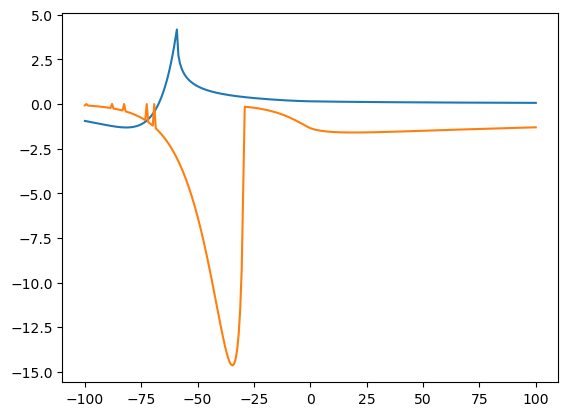

In [56]:
plt.plot(En, real_results)
plt.plot(En, imaginary_results)

In [25]:
# spectral function?
A =  -2* np.array(imaginary_results)/( (En - np.array(real_results))**2 + np.array(imaginary_results)**2)
plt.plot(En,A, color = 'red')
plt.ylim([0,0.04])
plt.vlines(x = -1/(2 * a_scat**2), ymin = 0, ymax = np.max(A), color = 'black', linestyles='--')
plt.grid()
plt.xlabel('$\omega + \mu$ (arb)', fontsize = 16)
plt.ylabel('Spectral function', fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.show()

NameError: name 'imaginary_results' is not defined

# <font size = 5>Same integrals, but with lab values?</font>

In [495]:
def NaK_imaginary_integrand(P, En, a_scat, beta, k):
    Eb = np.heaviside(a_scat, 0) * (hbar**2/(2 * a_scat**2 * muNa40K * u)) / h_planck # in Hz
    s = En + 50j - (mNa23 + mK40)*(P**2/(2*mNa23 + 2*mK40) - (P-k)**2/(2*mNa23)) # in Hz
    factor = (-4*np.pi / (2*np.pi)**3) * (mNa23 + mK40)**(3/2)
    T_matrix = (2*np.sqrt(2) / (muNa40K * u)**(3/2)) * np.sqrt(s)/ (s + Eb)
    return factor * (P**2) * np.exp(-beta * (mNa23 + mK40) * (P-k)**2/ (2 * mNa23)) * T_matrix

def NaK_real_integrand(P, En, a_scat, beta, k):
    Eb = np.heaviside(a_scat, 0)*(hbar**2/(2 * a_scat**2 * muNa40K * u)) / h_planck # in Hz
    s = En + 50j - ( mNa23 + mK40)*(P**2/(2*mNa23 + 2*mK40) - (P-k)**2/(2*mNa23) ) # in Hz
    factor = ((4 * np.pi) / (2*np.pi)**3 ) * (mNa23 + mK40)**(3/2)
    T_matrix = (2 * np.pi / (np.sqrt(2) * (muNa40K * u)**(3/2)) ) / (np.sign(a_scat)*np.sqrt(Eb) - np.sqrt(-s))
    return factor * (P**2) * np.exp(-beta * (mNa23 + mK40) * (P-k)**2/  (2 * mNa23)) * T_matrix

In [511]:
# temperature dependence?
dk = 1e1
dEn = 1e3
k_list = np.array([0]) # np.arange(0,1e2, dk)
ek = (hbar**2 * k**2 / (2 * muNa40K * u) ) / h_planck   # in Hz
momentum_cutoff = 3e3
T = 200e-9
a_scat_initial = -1700 * a0
a_scat_final = 1000 * a0 # 640 * a0
En = np.arange(-500e3,500e3,dEn)
points = len(En)
z = 0.6 # n * Lambda^3
beta = h_planck / (kB * T) 

A_conv = np.zeros(points)
# initial state
for k in k_list:
    # # initial state
    # imaginary_results_initial = []*points
    # real_results_initial = []*points
    # for i in range(points):
    #     real_results_initial.append(z*quad(NaK_real_integrand, 0, momentum_cutoff, args=(En[i], a_scat_initial, beta, k), epsabs=1e-6)[0])
    #     imaginary_results_initial.append(z*quad(NaK_imaginary_integrand, 0, momentum_cutoff, args=(En[i], a_scat_initial, beta, k), epsabs=1e-6)[0])
    # A_initial = -2*np.array(imaginary_results_initial)/( (En - k**2 + np.array(real_results_initial))**2 + np.array(imaginary_results_initial)**2)
    # A_initial = A_initial / np.linalg.norm(A_initial)
    # ######

    # final state
    imaginary_results_final = []*points
    real_results_final = []*points
    for i in range(points):
        real_results_final.append(z*quad(NaK_real_integrand, 0, momentum_cutoff, args=(En[i], a_scat_final, beta, k), epsabs=1e-6)[0])
        imaginary_results_final.append(z*quad(NaK_imaginary_integrand, 0, momentum_cutoff, args=(En[i], a_scat_final, beta, k), epsabs=1e-6)[0])
    A_final = -2*np.array(imaginary_results_final)/( (En - k**2 + np.array(real_results_final))**2 + np.array(imaginary_results_final)**2)
    A_final = A_final / np.linalg.norm(A_final)

    # A_conv += np.convolve(A_initial, A_final, mode='same') * k**2 * dk  * np.exp(-beta * k**2)
    ######

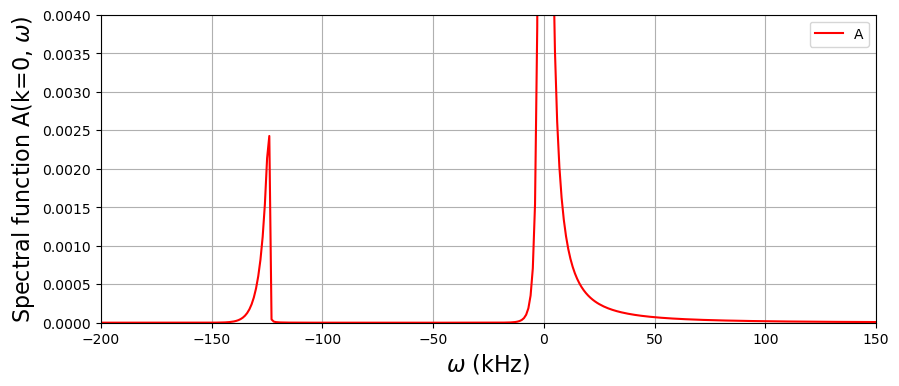

In [513]:
fig, ax = plt.subplots(figsize = (10,4))
ax.plot(En*1e-3, A_final, color = 'red', label = 'A')
plt.ylim([0,4e-3])
plt.xlim([-200, 150])
plt.grid()
plt.legend()
plt.xlabel('$\omega$ (kHz)', fontsize = 16)
plt.ylabel('Spectral function A(k=0, $\omega$)', fontsize = 16)
plt.show()

In [469]:
def rf_response():
    dk = 0.5e2
    dEn = 1e3
    k_array = np.arange(0, 1e3, dk)
    momentum_cutoff = 3e3
    T = 200e-9
    a_scat_initial = -1700 * a0
    a_scat_final = 640 * a0
    En = np.arange(-500e3,500e3,dEn)
    points = len(En)
    z = 1.8 # n * Lambda^3
    beta = h_planck / (kB * T) # in 1/Hz
    
    A_conv = np.zeros(points)

    for k in tqdm(range(len(k_array)), desc = 'Integrating over k...' ):
        k_val = k_array[k]
        # # initial state
        # imaginary_results_initial = []*points
        # real_results_initial = []*points
        # for i in range(points):
        #     real_results_initial.append(z*quad(NaK_real_integrand, 0, momentum_cutoff, args=(En[i], a_scat_initial, beta, k_val), epsabs=1e-6)[0])
        #     imaginary_results_initial.append(z*quad(NaK_imaginary_integrand, 0, momentum_cutoff, args=(En[i], a_scat_initial, beta, k_val), epsabs=1e-6)[0])
        # A_initial = -2*np.array(imaginary_results_initial)/( (En - k_val**2 + np.array(real_results_initial))**2 + np.array(imaginary_results_initial)**2)
        # A_initial = A_initial / np.linalg.norm(A_initial)
        # # A_conv += A_initial * k_val**2 * dk  * np.exp(-beta * k_val**2)
        # ######

        # final state
        imaginary_results_final = []*points
        real_results_final = []*points
        for i in range(points):
            real_results_final.append(z*quad(NaK_real_integrand, 0, momentum_cutoff, args=(En[i], a_scat_final, beta, k_val), epsabs=1e-6)[0])
            imaginary_results_final.append(z*quad(NaK_imaginary_integrand, 0, momentum_cutoff, args=(En[i], a_scat_final, beta, k_val), epsabs=1e-6)[0])
        A_final = -2*np.array(imaginary_results_final)/( (En - k_val**2 + np.array(real_results_final))**2 + np.array(imaginary_results_final)**2)
        A_final = A_final / np.linalg.norm(A_final)
        A_conv += A_final * k_val**2 * dk  * np.exp(-beta * k_val**2)
        ######        
        # convolve the two spectral functions:
        # A_conv += (dk) * k_val**2 * np.convolve(A_initial, A_final, 'same') * np.exp(-beta * k_val**2)
    A_conv = A_conv / np.linalg.norm(A_conv)
    return En, A_conv

In [470]:
w, rf = rf_response()

Integrating over k...: 100%|██████████| 20/20 [02:28<00:00,  7.44s/it]


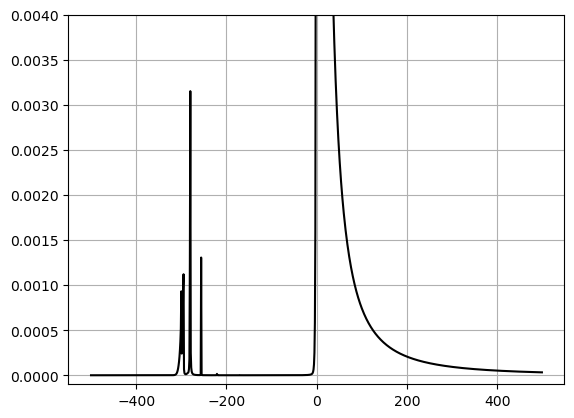

In [473]:
plt.plot(w*1e-3, rf, color = 'black')
plt.ylim([-0.0001, 0.004])
plt.grid()
plt.show()

In [510]:
# peak density = 0. um^-3
# T = 200e-9
l = h_planck / np.sqrt(kB*200e-9 * 2 * mNa23)
(l**3) * (0.2e18)

0.6010460140708787

# <font size = 5>New approach, model integrals</font>

In [559]:
from numba import jit
# F
@jit(nopython=False)
def integrand_F_1(x, P, En, Eb):
    return P**2 * np.exp(-P**2) * 4 * ( np.sqrt(x) / (x+Eb) ) / (En + 0.02j - (-P**2/2 + x))
@jit(nopython=False)
def real_integrand_F_1(x, P, En, Eb,k):
    return np.real(integrand_F_1(x, P, En, Eb))
@jit(nopython=False)
def imag_integrand_F_1(x, P, En, Eb,k):
    return np.imag(integrand_F_1(x, P, En, Eb))

@jit(nopython=False)
def integrand_F_2(P,En,Eb):
    return P**2 * np.exp(-P**2) * np.heaviside(Eb, 0) * 2*np.pi*Eb / (En + 0.02j - (-Eb - P**2/2))
@jit(nopython=False)
def real_integrand_F_2(P,En,Eb):
    return np.real(integrand_F_2(P,En,Eb))
@jit(nopython=False)
def imag_integrand_F_2(P,En,Eb):
    return np.imag(integrand_F_2(P,En,Eb))

# H 
@jit(nopython=False)
def integrand_H_1(x,P,En,Eb):
    return P**2 * np.exp(-P**2 - x) * 4 *( np.sqrt(x) / (x+Eb))  / (En + 0.02j - (-P**2/2 + x))
@jit(nopython=False)
def real_integrand_H_1(x,P,En,Eb):
    return np.real(integrand_H_1(x,P,En,Eb))
@jit(nopython=False)
def imag_integrand_H_1(x,P,En,Eb):
    return np.imag(integrand_H_1(x,P,En,Eb))

@jit(nopython=False)
def integrand_H_2(P,En,Eb):
    return P**2 * np.exp(-P**2 + Eb) * np.heaviside(Eb, 0) * 2 * np.pi * Eb / (En + 0.02j - (-Eb - P**2/2))
@jit(nopython=False)
def real_integrand_H_2(P,En,Eb):
    return np.real(integrand_2(P,En,Eb))
@jit(nopython=False)
def imag_integrand_H_2(P,En,Eb):
    return np.imag(integrand_2(P,En,Eb))

In [565]:
points = 300
cutoff = 400
P_cutoff = 400
Eb = 2
En = np.linspace(-6,8,points)

opts = {'epsrel':1e-5, 'limit':200, 'complex_func':False}
real_F = []*points
imag_F = []*points
real_H = []*points
imag_H = []*points

for i in tqdm(range(points)):
    # F1
    re_F_1,_ = nquad(real_integrand_F_1, [[-0,P_cutoff],[0, cutoff]], args = (En[i],Eb,1), opts=opts)
    im_F_1,_ = nquad(imag_integrand_F_1, [[-0,P_cutoff],[0, cutoff]], args = (En[i],Eb,1), opts=opts)
    # F2
    re_F_2 = quad(real_integrand_F_2, -0, P_cutoff, args = (En[i], Eb), complex_func=False)[0]
    im_F_2 = quad(imag_integrand_F_2, -0, P_cutoff, args = (En[i], Eb), complex_func=False)[0]

    re_F = re_F_1 + re_F_2
    im_F = im_F_1 + im_F_2

    real_F.append(re_F)
    imag_F.append(im_F)

    # # H1
    # re_H_1,_ = nquad(real_integrand_H_1, [[-0,P_cutoff],[0, cutoff]], args = (En[i],Eb), opts=opts)
    # im_H_1,_ = nquad(imag_integrand_H_1, [[-0,P_cutoff],[0, cutoff]], args = (En[i],Eb), opts=opts)
    # # H2
    # re_H_2 = quad(real_integrand_H_2, -0, P_cutoff, args = (En[i], Eb), complex_func=False)[0]
    # im_H_2 = quad(imag_integrand_H_2, -0, P_cutoff, args = (En[i], Eb), complex_func=False)[0]

    # re_H = re_H_1 + re_H_2
    # im_H = im_H_1 + im_H_2

    # real_H.append(re_H)
    # imag_H.append(im_H)

100%|██████████| 300/300 [01:13<00:00,  4.06it/s]


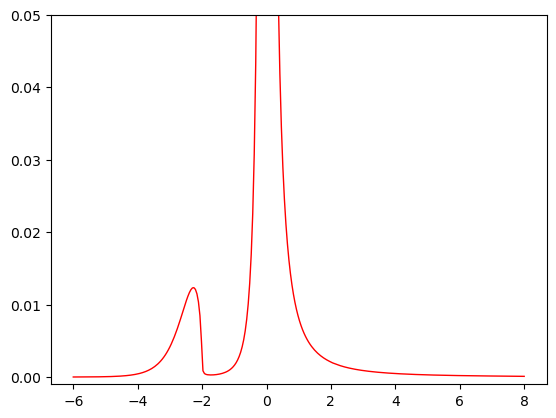

In [580]:
# make self energy, calculate spectral function and plot
z_array = np.array([0.17])
for z in z_array:
    real_Sigma = z * np.array(real_F) # +  0*z**2 * np.array(real_H)
    imag_Sigma = z * np.array(imag_F) # +  0*z**2 * np.array(imag_H)

    A =  -imag_Sigma/( (En*2*np.pi - real_Sigma)**2 + imag_Sigma**2 )
    plt.plot(En,A, linewidth = 1, color = 'red')
plt.ylim([-0.001,0.5e-1])    
plt.show()

# <font size = 5>New approach, lab values</font>

We want to evaluate the following integrals:

$$ F_1(k,E) = \int \frac{d^3P}{(2\pi)^3} e^{-\beta \frac{(P-k)^2}{2m_B}}
\left[\int_0^\infty dx \frac{\rho_2(x)}{E - \left( P^2/2M + x - (P-k)^2/2m_B \right)} 
+  \frac{ \Theta(a^{-1})Z_m}{E - \left( P^2/2M - E_b - (P-k)^2/2m_B \right)}\right] $$ 

and 

$$ H_1(k,E) = \int \frac{d^3P}{(2\pi)^3} 
\left[\int_0^\infty dx 
\frac{\rho_2(x) e^{-\beta (\frac{P^2}{2M}+x)} }{E - \left( P^2/2M + x - (P-k)^2/2m_B \right)} 
+  \frac{\Theta(a^{-1}) Z_m e^{-\beta (\frac{P^2}{2M}-E_b)}}{E - \left( P^2/2M - E_b - (P-k)^2/2m_B \right)}\right] $$ 

where 

$$
\rho_2(x) = \frac{2\sqrt{2}}{\mu^{3/2}}\frac{\sqrt{x}}{x + E_b} 
$$
and 
$$
Z_m = \frac{\pi}{\mu^2 a}.
$$

In [1107]:
# integral definitions
from numba import jit
# F
@jit # (nopython=False)
def integrand_F_1_NaK(x, p, En, beta, k):
    # M_over_m = 1.575(3)
    # beta is in units of Eb/kBT
    # En is in units of Eb 
    # p is in units of P * Sqrt[2*M_total*Eb]
    # k is in units of K * Sqrt[2*M_total*Eb]
    return p**2 * np.exp(-beta * 1.575 * (p-k)**2) * 4 * np.sqrt(x) / (x+1)  / (En + 0.002j - (p**2 + x - 1.575*(p-k)**2))
@jit # (nopython=False)
def real_integrand_F_1_NaK(x, p, En, beta, k):
    return np.real(integrand_F_1_NaK(x, p, En, beta, k))
@jit # (nopython=False)
def imag_integrand_F_1_NaK(x, p, En, beta, k):
    return np.imag(integrand_F_1_NaK(x, p, En, beta, k))

@jit # (nopython=False)
def integrand_F_2_NaK(p, En, beta, k, a_scat):
    # a_scat in units of a0
    # M_over_m = 1.575(3)
    # beta is in units of Eb/kBT
    # En is in units of Eb 
    # p is in units of P * Sqrt[2*M_total*Eb]
    # k is in units of K * Sqrt[2*M_total*Eb]
    return p**2 * np.exp(-beta * 1.575 * (p-k)**2) * np.heaviside(a_scat, 0) * 2*np.pi / (En + 0.002j - (p**2 - 1 - 1.575*(p-k)**2))
@jit # (nopython=False)
def real_integrand_F_2_NaK(p, En, beta, k, a_scat):
    return np.real(integrand_F_2_NaK(p, En, beta, k, a_scat))
@jit # (nopython=False)
def imag_integrand_F_2_NaK(p, En, beta, k, a_scat):
    return np.imag(integrand_F_2_NaK(p, En, beta, k, a_scat))

# H 
@jit # (nopython=False)
def integrand_H_1_NaK(x, p, En, beta, k):
    return p**2 * np.exp(-beta*(p**2 + x)) * 4 * np.sqrt(x) / (x+1)  /  (En + 0.002j - (p**2 + x - 1.575*(p-k)**2))
@jit # (nopython=False)
def real_integrand_H_1_NaK(x, p, En, beta, k):
    return np.real(integrand_H_1_NaK(x, p, En, beta, k))
@jit # (nopython=False)
def imag_integrand_H_1_NaK(x, p, En, beta, k):
    return np.imag(integrand_H_1_NaK(x, p, En, beta, k))

@jit # (nopython=False)
def integrand_H_2_NaK(p, En, beta, k, a_scat):
    return p**2 * np.exp(-beta * (p**2 - 1)) * np.heaviside(a_scat, 0) * 2*np.pi / (En + 0.002j - (p**2 - 1 - 1.575*(p-k)**2))
@jit # (nopython=False)
def real_integrand_H_2_NaK(p, En, beta, k, a_scat):
    return np.real(integrand_H_2_NaK(p, En, beta, k, a_scat))
@jit # (nopython=False)
def imag_integrand_H_2_NaK(p, En, beta, k, a_scat):
    return np.imag(integrand_H_2_NaK(p, En, beta, k, a_scat))

In [1035]:
# calculate integrals with lab values:
dEn = 1e3 # Hz
En = np.arange(-150e3,150e3,dEn)
points = len(En)
a_scat = 1200*a0
T = 200e-9 # Kelvins

# dimension-full stuff:
Eb = (hbar**2 / (2 * muNa40K * u * a_scat**2)) / h_planck # Eb in Hz
beta = 1/(kB*T/h_planck)
final_factor = (Eb / np.pi**2 ) * ((mNa23 + mK40) / (muNa40K * u)) ** (3/2) # in Hz
# dimension-less stuff:
dim_less_En = En / Eb
dim_less_beta = beta * Eb
dim_less_k = 0.04 # is the sqrt of the ratio between k^2/2mu and Eb!
k = dim_less_k * np.sqrt(2* (mNa23 + mK40) * Eb * h_planck)
Ek = (k**2 / (2 * muNa40K * u)) / h_planck # in Hz
dim_less_a_scat = a_scat / a0

x_cutoff = 90
p_cutoff = 90

opts = {'epsrel':1e-17, 'limit':700, 'complex_func':False}
real_F = []*points
imag_F = []*points

for i in tqdm(range(points)):
    # F1
    re_F_1,_ = nquad(real_integrand_F_1_NaK, [[0,x_cutoff],[0, p_cutoff]], args = (dim_less_En[i], dim_less_beta, dim_less_k), opts=opts)
    im_F_1,_ = nquad(imag_integrand_F_1_NaK, [[0,x_cutoff],[0, p_cutoff]], args = (dim_less_En[i], dim_less_beta, dim_less_k), opts=opts)
    # F2
    re_F_2 = quad(real_integrand_F_2_NaK, 0, p_cutoff, args = (dim_less_En[i], dim_less_beta, dim_less_k, dim_less_a_scat), 
                    epsrel = 1e-17, limit = 700)[0]
    im_F_2 = quad(imag_integrand_F_2_NaK, 0, p_cutoff, args = (dim_less_En[i], dim_less_beta, dim_less_k, dim_less_a_scat), 
                    epsrel = 1e-17, limit = 700)[0]

    re_F = re_F_1 + re_F_2
    im_F = im_F_1 + im_F_2

    real_F.append(final_factor * re_F)
    imag_F.append(final_factor * im_F)

real_F, imag_F = np.array(real_F), np.array(imag_F)


100%|██████████| 300/300 [01:01<00:00,  4.86it/s]


Eb: 85875.77870783447
Ek: 592.6940796082778


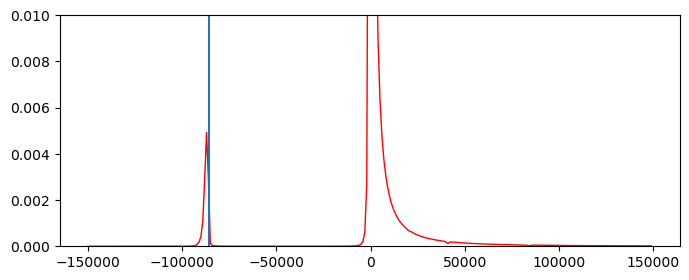

In [1038]:
# make self energy, calculate spectral function and plot
z_array = np.array([0.5])
print(f'Eb: {Eb}' )
print(f'Ek: {Ek}' )
fig, ax = plt.subplots(figsize = (8,3))
for z in z_array:
    real_Sigma = z * real_F # +  0 * z**2 * real_H
    imag_Sigma = z * imag_F # +  0 * z**2 * imag_H
    A =  -imag_Sigma/( (En - Ek - real_Sigma)**2 + imag_Sigma**2 )
    
    plt.plot(En,A/np.linalg.norm(A), linewidth = 1, color = 'red')
plt.vlines(x = -Eb, ymin = 0, ymax = 1)
plt.ylim([-0.1e-6,1e-2])    
plt.show()

# <font size = 5>From spectral function to RF response with k = 0 at various T</font>

In [1168]:
# helper functions
def Eb_Hz_from_a_scat(a_scat):
    return (hbar**2 / (2 * muNa40K * u * a_scat**2)) / h_planck

def self_energy_F(En, Eb, beta, a_scat, dim_less_k, x_cutoff, p_cutoff, opts):
    real_F = np.zeros(len(En))
    imag_F = np.zeros(len(En))
    for i in tqdm(range(len(En))):
        # F1
        re_F_1,_ = nquad(real_integrand_F_1_NaK, [[0,x_cutoff],[0, p_cutoff]], args = (En[i]/Eb, beta*Eb, dim_less_k), opts=opts)
        im_F_1,_ = nquad(imag_integrand_F_1_NaK, [[0,x_cutoff],[0, p_cutoff]], args = (En[i]/Eb, beta*Eb, dim_less_k), opts=opts)
        # F2
        re_F_2 = quad(real_integrand_F_2_NaK, 0, p_cutoff, args = (En[i]/Eb, beta*Eb, dim_less_k, a_scat/a0), epsrel = 1e-10, limit = 500)[0]
        im_F_2 = quad(imag_integrand_F_2_NaK, 0, p_cutoff, args = (En[i]/Eb, beta*Eb, dim_less_k, a_scat/a0), epsrel = 1e-10, limit = 500)[0]
        # combine to make F
        real_F[i] = re_F_1 + re_F_2
        imag_F[i] = im_F_1 + im_F_2
    E_scaling_factor = (Eb / np.pi**2 ) * ((mNa23 + mK40) / (muNa40K * u))
    return E_scaling_factor*real_F, E_scaling_factor*imag_F

def spectral_function(En, real_F, imag_F, Ek, z):
    real_Sigma = z * real_F
    imag_Sigma = z * imag_F
    return -imag_Sigma/( (En - Ek - real_Sigma)**2 + imag_Sigma**2 )

def z_from_n_and_T_boson(nB, T):
    # reference: M. Kardar Pg. 189 
    # T in Kelvins, n in um^-3
    lam = h_planck / np.sqrt(2 * np.pi * mNa23 * kB * T)
    nl3 = (nB * 1e+18) * lam**3
    eta = -1 # bosons
    return nl3 - (eta / 2**(3/2)) * nl3**2 + (1/4 - 1/3**(3/2)) * nl3**3

In [1170]:
# calculate the self-energies at each k
dEn = 1e3 # Hz
En = np.arange(-175e3,175e3,dEn)
T = np.array([100e-9, 200e-9, 300e-9, 400e-9]) # Kelvins
beta = 1/(kB*T/h_planck)

# scattering lengths
a_scat_final = 1200*a0
a_scat_initial = -1700*a0
Eb_final =  Eb_Hz_from_a_scat(a_scat_final)
Eb_initial =  Eb_Hz_from_a_scat(a_scat_initial)

x_cutoff = 80
p_cutoff = 80

n_quad_opts = {'epsrel':1e-10, 'limit':500, 'complex_func':False}

# calculate A final and initial
A_final_T = []*len(T)
A_initial_T = []*len(T)
for m in range(len(T)):
    print(f'Progress: {m+1}/{len(T)}')
    real_F_final, imag_F_final     = self_energy_F(En, Eb_final, beta[m], a_scat_final, 0, x_cutoff, p_cutoff, n_quad_opts)
    real_F_initial, imag_F_initial = self_energy_F(En, Eb_initial, beta[m], a_scat_initial, 0, x_cutoff, p_cutoff, n_quad_opts)
    A_final_T.append((real_F_final, imag_F_final))
    A_initial_T.append((real_F_initial, imag_F_initial))


Progress: 1/4


100%|██████████| 350/350 [01:32<00:00,  3.77it/s]


Progress: 2/4


100%|██████████| 350/350 [02:45<00:00,  2.12it/s]


Progress: 3/4


100%|██████████| 350/350 [04:13<00:00,  1.38it/s]


Progress: 4/4


100%|██████████| 350/350 [05:07<00:00,  1.14it/s]


In [1172]:
# construct spectral functions
z = z_from_n_and_T_boson(nB=0.88, T=T)
A_f = []*len(T)
A_i = []*len(T)
A_convolved = []*len(T)
for i in range(len(T)):
    A_f.append(spectral_function(En, A_final_T[i][0], A_final_T[i][1], 0, z[i]))
    A_i.append(spectral_function(En, A_initial_T[i][0], A_initial_T[i][1], 0, z[i]))
A_f = np.array(A_f)
A_i = np.array(A_i)
for j in range(len(T)):
    A_convolved.append(np.convolve(A_f[j], A_i[j], mode = 'same'))
A_convolved = np.array(A_convolved)

z: 0.18
Dimless k: 0.0
Eb: 85.88 kHz
T: 400.0 nK


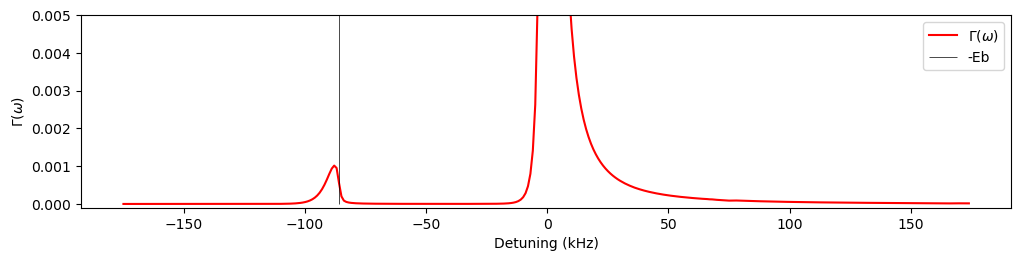

In [1185]:
fig, ax = plt.subplots(figsize = (12,2.5))
i = 3
plt.plot(En*1e-3, A_convolved[i] / np.linalg.norm(A_convolved[i]), color = 'red', label=r'$\Gamma(\omega)$')
print(f'z: {z[i]:.2f}')
print(f'Dimless k: {0.0}')
print(f'Eb: {Eb_final*1e-3:.2f} kHz')
print(f'T: {T[i]*1e9:.1f} nK')
plt.vlines(x = -Eb_final*1e-3, ymin = 0, ymax = 1, color = 'black', label = '-Eb', linewidth = 0.5)
plt.ylim([-0.0001,0.005])
plt.ylabel(r'$\Gamma$($\omega$)')
plt.xlabel('Detuning (kHz)')
plt.legend()
plt.show()


In [1149]:
# plot Cheng Chin's lineshape:
def CC_lineshape(x, T, Eb):
    beta = 1/(1e-3*kB*T/h_planck) # in 1/kHz
    print(beta)
    return (1/T**3) * np.exp(+x * beta) * np.sqrt(-x * Eb / (-x + Eb)**2)

0.23996215420391553


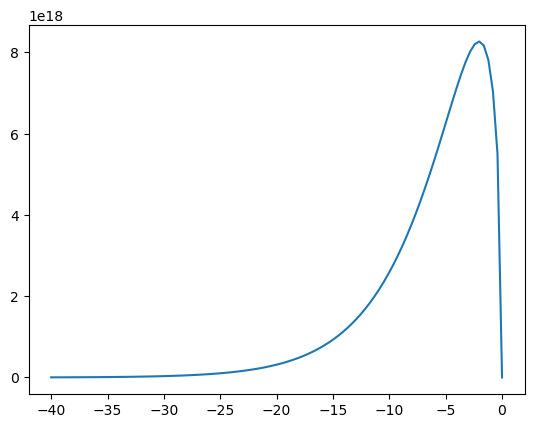

In [1154]:
x = np.linspace(-40, 0, 100)
Eb = 171.16
T = 200e-9
plt.plot(x, CC_lineshape(x,T,Eb))